In [1]:
# Core
import pandas as pd
import os
import numpy as np
from numpy import set_printoptions, sqrt, argmax, arange
from numpy.random import permutation
import scipy.stats as stats
from itertools import compress
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import pickle


#tsfresh
import tsfresh
from tsfresh.feature_extraction import extract_features, MinimalFCParameters, EfficientFCParameters
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

# Sklearn
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, precision_recall_curve
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.decomposition import PCA

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Self-defined functions
from Utilities import pdVarianceThreshold, pdSelectKBest, train_val_test_split, upsampling, SelectBestClf

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
direc = "E:\\WS4PD_data"
os.chdir(direc)
save_path = os.path.join(direc, "Model_validation", "GENEActiv_tremor")

# Load data

In [3]:
## Load scores
score_file_path = os.path.join(direc, 'Feature_extraction','score_by_device.pkl')
df_score = pd.read_pickle(score_file_path)

# Tremor: merge score 3 and 4
df_score['tremor_GENEActivHand'].loc[df_score['tremor_GENEActivHand']==4]=3
print('df_score:')
print(df_score.shape)

## load sensor features
subject_ids = df_score.subject_id.unique()
df_sensor_feature = pd.DataFrame()
device = 'GENEActiv'
for sb in subject_ids:
    feature_file_path = os.path.join(direc,'Feature_extraction',device,sb + '_features.pkl')
    df_sensor_feature_sb = pd.read_pickle(feature_file_path)
    df_sensor_feature = pd.concat([df_sensor_feature,df_sensor_feature_sb])
df_sensor_feature = df_sensor_feature.reset_index(drop=True)
df_sensor_feature = df_sensor_feature.dropna(axis=1)
print('df_sensor_feature:')
print(df_sensor_feature.shape)

## load clinical features
meta_file_path = os.path.join(direc, 'Feature_extraction','metadata_features.pkl')
df_clinical_feature = pd.read_pickle(meta_file_path)

# drop subject_id and task_code 
# df_clinical_feature.drop(columns = ['subject_id', 'task_code'])
df_clinical_feature = df_clinical_feature.drop(columns = 'subject_id')

# One-hot encoding clinical/ categorical features
categorical_columns = df_clinical_feature.columns
for column in categorical_columns:
    tempdf = pd.get_dummies(df_clinical_feature[column], prefix=column)
    df_clinical_feature = pd.merge(
        left=df_clinical_feature,
        right=tempdf,
        left_index=True,
        right_index=True,
    )
    df_clinical_feature = df_clinical_feature.drop(columns=column)
df_clinical_feature = df_clinical_feature.dropna(axis=1)
print('df_clinical_feature:')
print(df_clinical_feature.shape)

df_score:
(6909, 11)
df_sensor_feature:
(6909, 2247)
df_clinical_feature:
(6909, 69)


In [4]:
# Create a new label for each question

# Tremor
# 1. Can wearable sensor data predict tremor score? 
# df_score['newTremorLabel_GENEActivHand'] = df_score['tremor_GENEActivHand']
# title_name = 'Tremor score'
# save_name = 'tremor_score'
# xtick_name = [0,1,2,3,4]
# bin_range = range(5)

# 2. Can wearable sensor data predict whether tremor is present?
# is_tremor = df_score['tremor_GENEActivHand'].astype(int)>0
# df_score['newTremorLabel_GENEActivHand'] = np.nan
# df_score['newTremorLabel_GENEActivHand'].loc[is_tremor] = 1
# df_score['newTremorLabel_GENEActivHand'].loc[~is_tremor] = 0

# title_name = 'is_tremor'
# xtick_name = [0,1]
# bin_range = range(3)
# recall_1_threshold = 0.8

# 3. Can wearable sensor data predict whether tremor symptom is sever (score>2)? 
is_sever_tremor = df_score['tremor_GENEActivHand'].astype(int)>2
df_score['newTremorLabel_GENEActivHand'] = np.nan
df_score['newTremorLabel_GENEActivHand'].loc[is_sever_tremor] = 1
df_score['newTremorLabel_GENEActivHand'].loc[~is_sever_tremor] = 0

title_name = 'is_sever_tremor'
xtick_name = [0,1]
bin_range = range(3)
recall_1_threshold = 0.9

array([6766,  143], dtype=int64)

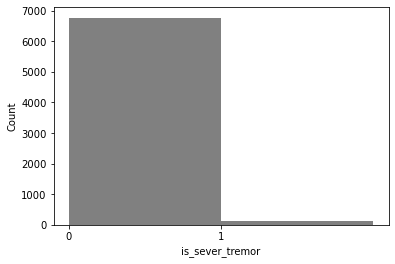

In [5]:
# Get new score distribution
score = df_score['newTremorLabel_GENEActivHand'].values
score = np.array(score, dtype=float)

# score distribution
counts, bin_edges = np.histogram(score,bins = bin_range)
fig, ax = plt.subplots()
ax.hist(score, bins = bin_range, histtype='bar', color = 'grey')
ax.set_xlabel(title_name)
ax.set_ylabel('Count')
ax.set_xticks(xtick_name)
# save figure
# plt.savefig(os.path.join(save_path,"Tremor_score_distribution"))
counts

# Upsample

In [6]:
upsample_size = round(max(counts)/2)
upsampled_df_score, upsampled_df_sensor_feature, upsampled_df_clinical_feature = upsampling(df_score, df_sensor_feature, df_clinical_feature, upsample_size, counts, score)
print('upsampled scores:' + str(upsampled_df_score.shape))
print('upsampled sensor features:' + str(upsampled_df_sensor_feature.shape))
print('upsampled clinical features:' + str(upsampled_df_clinical_feature.shape))

upsampled scores:(10149, 12)
upsampled sensor features:(10149, 2247)
upsampled clinical features:(10149, 69)


In [7]:
df_score = upsampled_df_score
df_sensor_feature = upsampled_df_sensor_feature
df_clinical_feature = upsampled_df_clinical_feature

# Feature selection

In [8]:
# Remove features with zero variance
varThreshold = 0.001
df_sensor_feature = pdVarianceThreshold(df_sensor_feature,varThreshold)
df_clinical_feature = pdVarianceThreshold(df_clinical_feature,varThreshold)

print('sensor features:' + str(df_sensor_feature.shape))
print('clinical features:' + str(df_clinical_feature.shape))

# Combine sensor features with clinical features
df = pd.concat([df_sensor_feature, df_clinical_feature], axis=1) 

sensor features:(10149, 2034)
clinical features:(10149, 64)


In [9]:
# Train/Validation/Test Split
# Get scores
score = df_score['newTremorLabel_GENEActivHand'].values
score = np.array(score, dtype=float)
# Get subject ids for splitting
subject_id = df_score['subject_id']

X_train_valid, y_train_valid, X_train, y_train,  X_valid, y_valid, X_test, y_test = train_val_test_split(df, score, subject_id)


In [10]:
# df_sensor_feature: numerical input
# df_clinical_feature: categorical input
# use chi2f_classif for SelectKBest

# Univariant selection for sensor features
X_train_sf_sensor = pdSelectKBest(X_train.iloc[:,0:df_sensor_feature.shape[1]], y_train, f_classif, 20)
sensor_sf_index = X_train_sf_sensor.columns

X_valid_sf_sensor = X_valid.loc[:,sensor_sf_index]
X_train_valid_sf_sensor = X_train_valid.loc[:,sensor_sf_index]
X_test_sf_sensor = X_test.loc[:,sensor_sf_index]
sensor_sf_index

C:\Users\Yiting\Anaconda3\envs\ws4pd\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [671] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Yiting\Anaconda3\envs\ws4pd\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Index(['x__absolute_sum_of_changes', 'x__autocorrelation__lag_2',
       'x__autocorrelation__lag_3',
       'x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0',
       'x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0',
       'x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0',
       'x__cid_ce__normalize_False', 'x__fft_aggregated__aggtype_"skew"',
       'x__mean_abs_change', 'x__number_crossing_m__m_-1',
       'x__partial_autocorrelation__lag_4', 'z__absolute_sum_of_changes',
       'z__autocorrelation__lag_2', 'z__autocorrelation__lag_3',
       'z__autocorrelation__lag_4', 'z__autocorrelation__lag_5',
       'z__cid_ce__normalize_False', 'z__fft_aggregated__aggtype_"skew"',
       'z__mean_abs_change', 'z__partial_autocorrelation__lag_4'],
      dtype='object')

In [11]:
# df_clinical_feature: categorical input
# score: categorical output
# use chi2 for SelectKBest

# Univariant selection for clinical features
X_train_sf_clinical = pdSelectKBest(X_train.iloc[:,df_sensor_feature.shape[1]:-1], y_train, chi2, 4)
clinical_sf_index = X_train_sf_clinical.columns

X_valid_sf_clinical = X_valid.loc[:,clinical_sf_index]
X_train_valid_sf_clinical = X_train_valid.loc[:,clinical_sf_index]
X_test_sf_clinical = X_test.loc[:,clinical_sf_index]
clinical_sf_index

Index(['age_group_4.0', 'age_diagnosis_group_2.0', 'tremor_No',
       'disrupted_sleep_No'],
      dtype='object')

In [12]:
X_train_sf = pd.concat([X_train_sf_sensor, X_train_sf_clinical], axis=1) 
X_valid_sf = pd.concat([X_valid_sf_sensor, X_valid_sf_clinical], axis=1) 
X_train_valid_sf = pd.concat([X_train_valid_sf_sensor, X_train_valid_sf_clinical], axis=1) 
X_test_sf = pd.concat([X_test_sf_sensor, X_test_sf_clinical], axis=1) 

X_train_sf = X_train_sf.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_valid_sf = X_valid_sf.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_train_valid_sf = X_train_valid_sf.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test_sf = X_test_sf.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


# Model selection

In [13]:
# Classifiers
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=7, solver = 'liblinear'),
    "KNN" : KNeighborsClassifier(),
#     "SVC" : SVC(random_state=7, probability=True),
    "RandomForest" : RandomForestClassifier(random_state=7),
    "XGBoost" : XGBClassifier(random_state=7, use_label_encoder=False, eval_metric='logloss'), # XGBoost takes too long
    "LGBM" : LGBMClassifier(random_state=7),
    "CatBoost" : CatBoostClassifier(random_state=7, verbose=False),
    "NaiveBayes": GaussianNB()
}

# Grids for grid search
LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150, 200, 250]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

# SVC_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
#             'kernel': ['linear', 'rbf'],
#             'gamma': ['scale', 'auto']}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [2, 4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15]}

NB_grid={'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7]}

# Dictionary of all grids
grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
#     "SVC" : SVC_grid,
    "RandomForest" : RF_grid,
    "XGBoost" : boosted_grid,
    "LGBM" : boosted_grid,
    "CatBoost" : boosted_grid,
    "NaiveBayes": NB_grid
}

In [14]:
# Classifier evaluation
i=0
clf_best_params=classifiers.copy()
valid_scores=pd.DataFrame({'Classifer':classifiers.keys(),
                           'Accuracy': np.zeros(len(classifiers)),
                           'F1_macro': np.zeros(len(classifiers)),
                           'F1_micro': np.zeros(len(classifiers)),
                           'F1_weighted': np.zeros(len(classifiers)),
                           'F1_0': np.zeros(len(classifiers)),
                           'F1_1': np.zeros(len(classifiers)),                               
                           'Precision_0': np.zeros(len(classifiers)),
                           'Precision_1': np.zeros(len(classifiers)),
                           'Recall_0': np.zeros(len(classifiers)),
                           'Recall_1': np.zeros(len(classifiers)),
                           'Training time': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    # Train and score
    clf.fit(X_train_sf, y_train)
    y_pred = clf.predict(X_valid_sf)
    Accuracy = accuracy_score(y_valid, y_pred).round(2)
    F1_macro = f1_score(y_valid, y_pred, average = 'macro').round(2)
    F1_micro = f1_score(y_valid, y_pred, average = 'micro').round(2)
    F1_weighted = f1_score(y_valid, y_pred, average = 'weighted').round(2)
    F1_class = f1_score(y_valid, y_pred, average = None).round(2)
    Precision = precision_score(y_valid, y_pred, average = None).round(2)
    Recall = recall_score(y_valid, y_pred, average = None).round(2)                                         

    valid_scores.iloc[i,1]=Accuracy
    valid_scores.iloc[i,2]=F1_macro
    valid_scores.iloc[i,3]=F1_micro
    valid_scores.iloc[i,4]=F1_weighted
    valid_scores.iloc[i,5]=F1_class[0]
    valid_scores.iloc[i,6]=F1_class[1]
    valid_scores.iloc[i,7]=Precision[0]
    valid_scores.iloc[i,8]=Precision[1] 
    valid_scores.iloc[i,9]=Recall[0]
    valid_scores.iloc[i,10]=Recall[1]

    # Save trained model
    clf_best_params[key]=clf.best_params_

    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,11]=np.round((stop - start)/60, 2)


    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,11])
    print('')
    i+=1


Model: LogisticRegression
Training time (mins): 0.28

Model: KNN
Training time (mins): 0.03

Model: RandomForest
Training time (mins): 0.41

Model: XGBoost
Training time (mins): 0.43

Model: LGBM
Training time (mins): 0.1

Model: CatBoost
Training time (mins): 9.37

Model: NaiveBayes
Training time (mins): 0.0



In [15]:
valid_scores

,Classifer,Accuracy,F1_macro,F1_micro,F1_weighted,F1_0,F1_1,Precision_0,Precision_1,Recall_0,Recall_1,Training time
0,LogisticRegression,0.93,0.92,0.93,0.93,0.94,0.89,0.94,0.89,0.95,0.88,0.28
1,KNN,0.77,0.69,0.77,0.74,0.85,0.53,0.76,0.80,0.95,0.40,0.03
2,RandomForest,0.79,0.70,0.79,0.76,0.86,0.55,0.77,0.92,0.98,0.39,0.41
3,XGBoost,0.84,0.79,0.84,0.82,0.89,0.68,0.81,0.93,0.98,0.54,0.43
4,LGBM,0.82,0.75,0.82,0.80,0.88,0.63,0.79,0.93,0.98,0.48,0.10
5,CatBoost,0.82,0.77,0.82,0.81,0.88,0.65,0.80,0.92,0.98,0.51,9.37
6,NaiveBayes,0.87,0.86,0.87,0.87,0.90,0.82,0.94,0.76,0.87,0.88,0.00


In [16]:
best_clf_summary = SelectBestClf(valid_scores, recall_1_threshold, clf_best_params)
best_clf = best_clf_summary[2]
best_clf_params = best_clf_summary[3]
print(best_clf)

LogisticRegression


In [17]:
best_clf_summary

(0.93,
 0.88,
 'LogisticRegression',
 {'C': 0.25, 'max_iter': 50, 'penalty': 'l2'})

In [ ]:
# Adjusting model threshold 

In [21]:
clf = LogisticRegression(random_state=7, solver = 'liblinear',
                         C=0.25, max_iter = 50, penalty = 'l2')
clf.fit(X_train_sf, y_train)

LogisticRegression(C=0.25, max_iter=50, random_state=7, solver='liblinear')

In [ ]:
# clf = GaussianNB(var_smoothing= 1e-07)
# clf.fit(X_train_sf, y_train)

In [ ]:
# clf = XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss',
#                     learning_rate= 0.05, max_depth= 4, n_estimators= 50)
# clf.fit(X_train_sf, y_train)

C:\Users\Yiting\Anaconda3\envs\ws4pd\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


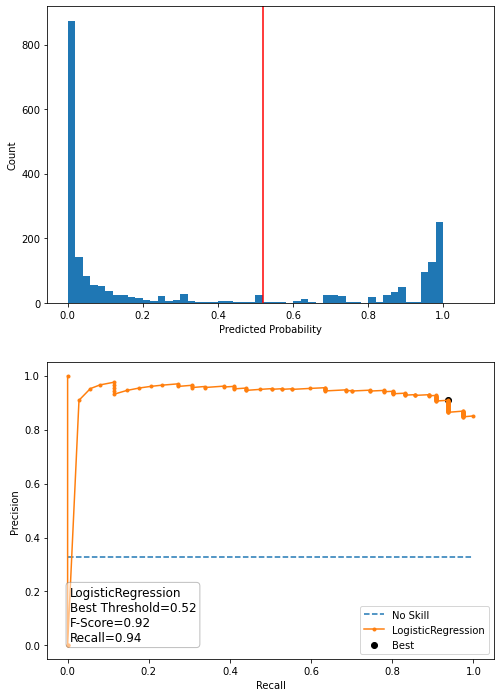

In [30]:
# Choose the best threshold
# Recall is above the recall threshold
# Select the best F1 score 

# Predict probabilities
yhat = clf.predict_proba(X_valid_sf)
# Keep probabilities for the positive outcome only
probs = yhat[:, 1]
# Calculate pr curves
precision, recall, thresholds = precision_recall_curve(y_valid, probs)
# Convert to f score
fscore = (2 * precision * recall) / (precision + recall)

# Select recall is above the recall threshold                
is_good_recall = recall > recall_1_threshold
# locate the index of the largest f score
ix = argmax(fscore[is_good_recall])

# Predict the class using the new threhold 
new_y_pred = probs > thresholds[ix]

# Plot
fig, (ax0, ax1) = plt.subplots(2,1, figsize=(8,12))
## Histogram of prediction probability 
ax0.hist(probs, bins = np.arange(0, 1.1, 0.02))
ax0.axvline(x = thresholds[ix], color = 'r', label = 'new threshold')
ax0.set_xlabel('Predicted Probability')
ax0.set_ylabel('Count')
## PR curve
no_skill = len(y_valid[y_valid==1]) / len(y_valid)
ax1.plot([0,1], [no_skill, no_skill], linestyle='--', label='No Skill')
ax1.plot(recall, precision, marker='.', label=best_clf)
ax1.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.legend()
def lowerlefttext(ax,text, size=12, alpha = 0.5, color='k', dx=1.0/20, dy=1.0/20):
    return ax.annotate(text, xy=(dx, dy), xycoords = 'axes fraction',
                        ha='left',va='bottom',ma='left',color=color,      
                        size=size, bbox=dict(boxstyle="round", fc="w",
                        ec="0.5", alpha=alpha))
lowerlefttext(ax1,best_clf + '\nBest Threshold=%.2f\nF-Score=%.2f\nRecall=%.2f' % (thresholds[ix], fscore[ix], recall[ix]))

# save figure
file_name = title_name + '_threshold'
plt.savefig(os.path.join(save_path,"Threshold",file_name))

In [ ]:
# Finalized model

In [27]:
clf.fit(X_train_valid_sf, y_train_valid)
yhat = clf.predict_proba(X_test_sf)
# Keep probabilities for the positive outcome only
probs = yhat[:, 1]
# Predict the class using the new threhold 
new_y_pred = probs > thresholds[ix]
Accuracy = accuracy_score(y_test, new_y_pred).round(2)
F_score = f1_score(y_test, new_y_pred).round(2)
Precision = precision_score(y_test, new_y_pred, average = None).round(2)
Recall = recall_score(y_test, new_y_pred, average = None).round(2)      

In [28]:
# save the model to disk
model_file_name = 'Finalized_model_' + title_name + '.sav'
model_file_path = os.path.join(direc, "Finalized_Models", model_file_name)
pickle.dump(clf, open(model_file_path, 'wb'))

In [31]:
# Save
df_model_metadata = pd.DataFrame({
    'title': [title_name],
    'max_sample_size': [max(counts)],
    'upsample_size': [upsample_size],
    'selected_sensor_features':[sensor_sf_index],
    'selected_clinical_features':[clinical_sf_index],
    'validation_scores_for_all_models': [valid_scores],
    'best_clf': [best_clf],
    'best_clf_params': [best_clf_params],
    'target_recall': [recall_1_threshold],
    'best_threshold': [thresholds[ix]],
    'finalized_model_file_path': [model_file_path],
    'F_score': [F_score],
    'Precision':[Precision],
    'Recall':[Recall]},
    index=[0])
model_metadata_name = 'Metadata_of_finalized_model_' + title_name +'.pkl'
model_metadata_path = os.path.join(direc, "Finalized_Models", model_metadata_name)
df_model_metadata.to_pickle(model_metadata_path)


In [ ]:
# 